In [2]:
import plotly
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

Please enter the desired confidence interval?
0.95


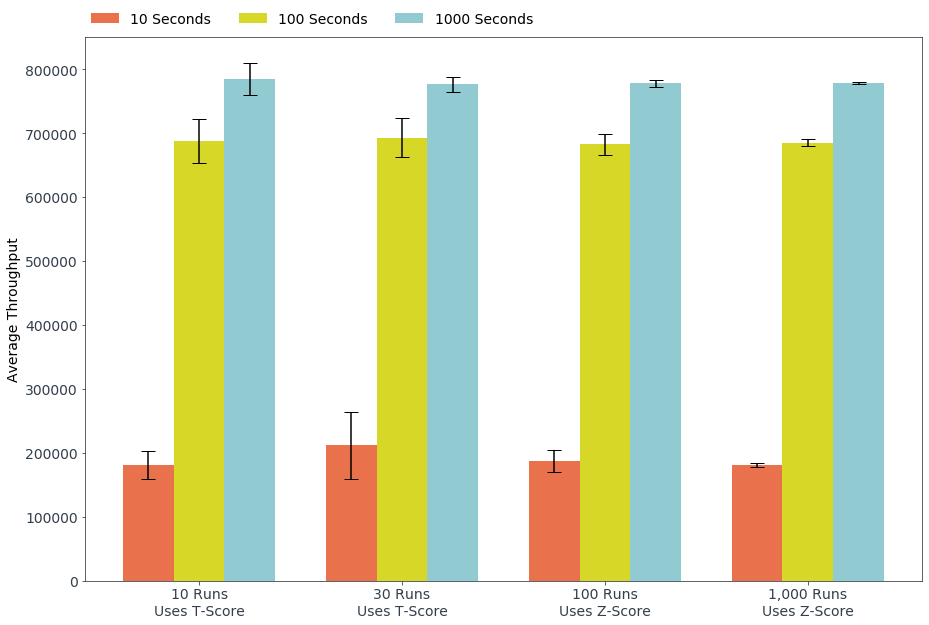

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import style
import math
import decimal
import statistics
from scipy import stats


class Result_Analysis():
        
    def read_file(self, file_number):
        dict_ = {1: 'Ten_Runs_avg-throughput_scalar.csv',
                 2: 'Thirty_Runs_avg-throughput_scalar.csv',
                 3: 'Hundred_Runs_avg-throughput_scalar.csv',
                 4: 'Thousand_Runs_avg-throughput_scalar.csv'
                }
        cols = ['run', 'ber', 'timelimit', 'repetition', 'Module', 'Avg_Throughput']
        data = pd.read_csv(dict_[file_number], delimiter=',', skiprows=[0], names=cols)

        df = pd.DataFrame(data)
        
        avgTP_10s_arr = []
        avgTP_100s_arr = []
        avgTP_1000s_arr = []

        for i in range(len(data)):
            if (df['timelimit'][i] == 10):
                avgTP_10s_arr.append(df['Avg_Throughput'][i])
            elif (df['timelimit'][i] == 100):
                avgTP_100s_arr.append(df['Avg_Throughput'][i])
            elif (df['timelimit'][i] == 1000):
                avgTP_1000s_arr.append(df['Avg_Throughput'][i])
                
        arrays = {'array_10': avgTP_10s_arr, 
                  'array_100': avgTP_100s_arr,
                  'array_1000': avgTP_1000s_arr
                 }
        return arrays
    
    # Sample variance = SUM((x_i - x_bar)^2) / (n - 1)
    # Sample standard deviation = sqrt(sample variance)
    
    # sampleVariance = 0
    # for i, val in enumerate(arr):
    #    sampleVariance += (val - sampleMean(arr))**2
    # sampleVariance = sampleVariance / (len(arr) - 1)
    # return math.sqrt(sampleVariance)
    
    def SampleStDev(self, arrays):
        sample_stdev = []
        for key, value in arrays.items():
            sample_stdev.append(statistics.stdev(value))
        return sample_stdev
    
    def sampleMean(self, arrays):
        sample_mean = []
        for key, value in arrays.items():
            sample_mean.append(statistics.mean(value))
        return sample_mean
    
    # We assume we know the population standard deviation. For n <= 30, use T-Score. For n > 30, use Z-Score.
    
    def tScore(self, conf, arrays):
        t_scores = []
        for inner_array in arrays.values():
            t_scores.append(stats.t.ppf((conf + 1) / 2, len(inner_array))) 
        return t_scores


    def confInterval_t(self, conf, arrays, sample_mean, sample_stdev, t_scores):
        for inner_array in arrays.values():
            length = len(inner_array)
        
        upper_t = list((x-y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        lower_t = list((x+y for x,y in zip(sample_mean, 
                                           (a*b/math.sqrt(length) for a,b in zip(t_scores, sample_stdev)))))
        
        return lower_t, upper_t
    
    def confInterval_z(self, con_coef, arrays, sample_mean, sample_stdev):
        z_interval_l, z_interval_r = stats.norm.interval(con_coef)
        for inner_array in arrays.values():
            length = len(inner_array)
            
        lower_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_l*element/ math.sqrt(length) for element in sample_stdev)))
        upper_z = list(x + y for x, y in zip(sample_mean, 
                                              (z_interval_r*element/ math.sqrt(length) for element in sample_stdev)))
        
        return lower_z, upper_z


run = True
while run:
    try:
        confidence_interval = float(input("Please enter the desired confidence interval?\n"))
        if 0 >= confidence_interval > 1:
            raise Exception 
                   
    except:
        print("Please enter a valid number!")
        
    else:
        mean_dict = {}
        t_dict = {}
        z_dict = {}
        for number in range(1,5):
            file_number = number

            obj = Result_Analysis()
            mean = obj.sampleMean(obj.read_file(file_number))
            mean_dict[number] = mean
            
            stdev = obj.SampleStDev(obj.read_file(file_number))
            tscore = obj.tScore(confidence_interval, obj.read_file(file_number))

            t_score_l, t_score_r = obj.confInterval_t(confidence_interval, obj.read_file(file_number), mean, stdev, tscore)
            t_dict[number] = [(x,y) for x,y in zip(t_score_l, t_score_r)]
            
            z_score_l, z_score_r = obj.confInterval_z(confidence_interval, obj.read_file(file_number), mean, stdev)
            z_dict[number] = [(x,y) for x,y in zip(z_score_l, z_score_r)]
            
        #Plot the data
            
        # width of the bars
        barWidth = 0.25
 
        # Choose the height of the bars
        bars_10s = [mean_dict[1][0], mean_dict[2][0], mean_dict[3][0], mean_dict[4][0]]
        bars_100s = [mean_dict[1][1], mean_dict[2][1], mean_dict[3][1], mean_dict[4][1]]
        bars_1000s = [mean_dict[1][2], mean_dict[2][2], mean_dict[3][2], mean_dict[4][2]]
        
        # Choose the height of the confidence interval (error bars)
        yer_10s = [t_dict[1][0][1] - t_dict[1][0][0], t_dict[2][0][1] - t_dict[2][0][0], 
                   z_dict[3][0][1] - z_dict[3][0][0], z_dict[4][0][1] - z_dict[4][0][0]]
        yer_100s = [t_dict[1][1][1] - t_dict[1][1][0], t_dict[2][1][1] - t_dict[2][1][0], 
                   z_dict[3][1][1] - z_dict[3][1][0], z_dict[4][1][1] - z_dict[4][1][0]]
        yer_1000s = [t_dict[1][2][1] - t_dict[1][2][0], t_dict[2][2][1] - t_dict[2][2][0], 
                   z_dict[3][2][1] - z_dict[3][2][0], z_dict[4][2][1] - z_dict[4][2][0]]
 
        # The x position of bars
        r_10s = np.arange(len(bars_10s))
        r_100s = [x + barWidth for x in r_10s]
        r_1000s = [x + barWidth for x in r_100s]

        plt.figure(figsize = (15,10))
        
        plt.rcParams['axes.edgecolor']='#333F4B'
        plt.rcParams['axes.linewidth']=0.8
        plt.rcParams['xtick.color']='#333F4B'
        plt.rcParams['ytick.color']='#333F4B'
        plt.rcParams.update({'font.size': 14})
        
        # Create 10s bars
        plt.bar(r_10s, bars_10s, width = barWidth, color = '#e9724d', yerr=yer_10s, capsize=7, label='10 Seconds')
        #plt.errorbar(x1, y1, yerr=yerr1, capsize=2, capthick=1, label='CG')
        # Create 100s bars
        plt.bar(r_100s, bars_100s, width = barWidth, color = '#d6d727', yerr=yer_100s, capsize=7, label='100 Seconds')
        
        # Create 1000s bars
        plt.bar(r_1000s, bars_1000s, width = barWidth, color = '#92cad1', yerr=yer_1000s, capsize=7, label='1000 Seconds')
 
        # general layout
        plt.xticks([r + barWidth for r in range(len(bars_10s))], ['10 Runs\nUses T-Score', '30 Runs\nUses T-Score',
                                                                  '100 Runs\nUses Z-Score', '1,000 Runs\nUses Z-Score'])
        plt.ylabel('Average Throughput')
        plt.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=3,
            borderaxespad=0, frameon=False)

        # Show graphic
        plt.show()
    
        #print(f'\n\n\nCI based on T-score: \n{t_dict}')
        #print(f'\n\n\nCI based on Z-score: \n{z_dict}')
        #print(f'\n\n\nMean:{mean_dict}')
        
        run = False            